# Preparing data for statistical modeling and generating descriptive statistics
*Julie Nguyen, PhD candidate in Management (Organizational Behavior), McGill University*

Welcome to the next phase of our journey into understanding the factors that shape movie directors' career! In this notebook, we'll bring together all the data we've prepared so far to test whether a director's success is influenced by the brokerage social capital of the people they work with, and whether men and women derive similar benefits from their collaborators' social capital.

**What have we done so far?**
- Identified directors who debuted between 2003 and 2013 (`Phase_1_Tracking_Movie_Directors_Career.ipynb`).
- Tracked their productivity and career longevity using panel data and cross-sectional data (`Phase_2_Building_Time_Series_Data.ipynb`).
- Calculated their brokerage social capital and that of their collaborators at each year in their career (`Phase_3_Constructing_Filmmaker_Network.ipynb` and  `Phase_4_Incorporating_Network_Variables_to_Career_Data.ipynb`).
- Predicted their gender based on first names (`Phase_5_Predicting_Gender_From_Names.ipynb`).
- Constructed control variables to account for various confounding factors (`Phase_6_Constructing_Control_Variables.ipynb`).

**What are we aiming to do now?**

Now, we will assemble all these elements to create a cohesive dataset. Our focus will be on building both the panel data and cross-sectional data using the main variables of interest (collaborators' brokerage social capital and directors' gender) and control variables. While we have calculated several metrics, we will initially focus on the main metric for brokerage social capital—effective size.

**Looking Ahead**

By the end of this notebook, we will have two datasets: a cross-sectional dataset and a panel dataset, with all relevant variables. This will enable us to perform statistical modeling to test our hypotheses about the impact of collaborators' social capital on directors' career success.

# 1. Preparing the cross-sectional data on directors' first decade following debut

The cross-sectional dataset will have the following column:
- 'nconst_director': Unique identifier for each director.
- 'debut_year': The year a director directed their first movie.
- 'time_to_second_movie': Time taken for a director to make another movie within 10 years following their debut.
- 'event': Indicator variable for whether a director made another movie within 10 years following their debut.
- 'total_movies': Number of movies a director made within 10 years following their debut.
- 'debut_collaborator_avg_effective_size': Brokerage social capital of the collaborators a director worked with on their debut movie.
- 'director_predicted_gender': Gender of the director predicted from their first name.
- 'had_prior_experience': Indicator for whether a director had prior experience in filmmaking roles before their directorial debut.
- 'collaborator_movie_ratings': Average ratings of the movies collaborators worked on three years before working with the director.
- 'collaborator_movie_votes': Number of votes for the movies collaborators worked on three years before working with the director.
- 'debut_year_2004' to 'debut_year_2013': Dummy variables for the director's debut year to control for industry conditions at the time of debut, with 2003 as the reference year.

## 1.1. Compiling the data

In [45]:
# Importing necessary libraries for data manipulation and handling
import pandas as pd  # data manipulation
import os # interacting with operating system
import numpy as np
from scipy.stats import mstats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import pearsonr

# Set the working directory to where the project files are located
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')

In [62]:
# Load the datasets
file_paths = {
    "directors_gender": "directors_gender.csv",
    "directors_collaborator_social_capital": "directors_cross_sectional_social_capital.csv",
    "directors_career_outcomes": "directors_cross_sectional.csv",
    "directors_control_variables": "directors_cross_sectional_control_variables.csv"
}

datasets = {name: pd.read_csv(path) for name, path in file_paths.items()}

# Print column names for each dataset
for name, df in datasets.items():
    print(f"Column names in {name}:")
    print(df.columns)
    print("\n")


Column names in directors_gender:
Index(['nconst_director', 'director_predicted_gender',
       'director_predicted_gender_binary'],
      dtype='object')


Column names in directors_collaborator_social_capital:
Index(['nconst_director', 'debut_num_collaborators',
       'debut_collaborator_avg_constraint',
       'debut_collaborator_max_constraint',
       'debut_collaborator_avg_local_clustering',
       'debut_collaborator_max_local_clustering',
       'debut_collaborator_avg_reverse_constraint',
       'debut_collaborator_max_reverse_constraint',
       'debut_collaborator_avg_effective_size',
       'debut_collaborator_max_effective_size',
       'debut_collaborator_avg_reverse_local_clustering',
       'debut_collaborator_max_reverse_local_clustering',
       'debut_collaborator_avg_degree_centrality',
       'debut_collaborator_max_degree_centrality'],
      dtype='object')


Column names in directors_career_outcomes:
Index(['nconst_director', 'debut_year', 'time_to_second_movie

In [63]:
# Merge the datasets
directors_cross_sectional_complete = datasets["directors_career_outcomes"]

directors_cross_sectional_complete = directors_cross_sectional_complete.merge(
    datasets["directors_collaborator_social_capital"][['nconst_director', 'debut_collaborator_avg_effective_size']], 
    on="nconst_director", how="left")

directors_cross_sectional_complete = directors_cross_sectional_complete.merge(
    datasets["directors_gender"], 
    on=["nconst_director"], how="left")

directors_cross_sectional_complete = directors_cross_sectional_complete.merge(
    datasets["directors_control_variables"][['nconst_director', 'had_prior_experience', 'collaborator_movie_ratings', 'collaborator_movie_votes'] +
                                            [col for col in datasets["directors_control_variables"].columns if col.startswith('debut_year_')]], 
    on="nconst_director", how="left")

In [4]:
directors_cross_sectional_complete.head()

,nconst_director,debut_year,time_to_second_movie,event,total_movies,debut_collaborator_avg_effective_size,director_predicted_gender,director_predicted_gender_binary,had_prior_experience,collaborator_movie_ratings,...,debut_year_2004,debut_year_2005,debut_year_2006,debut_year_2007,debut_year_2008,debut_year_2009,debut_year_2010,debut_year_2011,debut_year_2012,debut_year_2013
0,nm1131265,2004,9.0,1,1.0,3.666667,Male,0.0,0,7.325,...,1,0,0,0,0,0,0,0,0,0
1,nm1130611,2004,11.0,0,0.0,3.666667,Female,1.0,0,7.325,...,1,0,0,0,0,0,0,0,0,0
2,nm0290651,2003,11.0,0,0.0,2.600000,Ambiguous,NaN,0,4.950,...,0,0,0,0,0,0,0,0,0,0
3,nm0404033,2003,5.0,1,1.0,4.219048,NaN,NaN,0,4.960,...,0,0,0,0,0,0,0,0,0,0
4,nm0000417,2005,2.0,1,1.0,1.857143,Male,0.0,1,5.750,...,0,1,0,0,0,0,0,0,0,0


## 1.2. Descriptive statistics and variable transformation 

In [47]:
# Generate descriptive statistics for continuous variables
continuous_vars = ['total_movies', 'time_to_second_movie', 'debut_collaborator_avg_effective_size', 
                   'collaborator_movie_ratings', 'collaborator_movie_votes']

pd.set_option('display.float_format', lambda x: '%.2f' % x)  
directors_cross_sectional_complete[continuous_vars].describe()

,total_movies,time_to_second_movie,debut_collaborator_avg_effective_size,collaborator_movie_ratings,collaborator_movie_votes
count,63169.00,63169.00,58869.00,40458.00,40458.00
mean,0.77,8.50,3.35,6.38,21041.95
std,1.80,3.64,7.63,1.21,165668.46
min,0.00,1.00,0.00,1.00,5.00
25%,0.00,5.00,1.00,5.70,34.00
50%,0.00,11.00,1.63,6.42,238.50
75%,1.00,11.00,3.74,7.15,2220.75
max,126.00,11.00,337.38,10.00,9762716.00


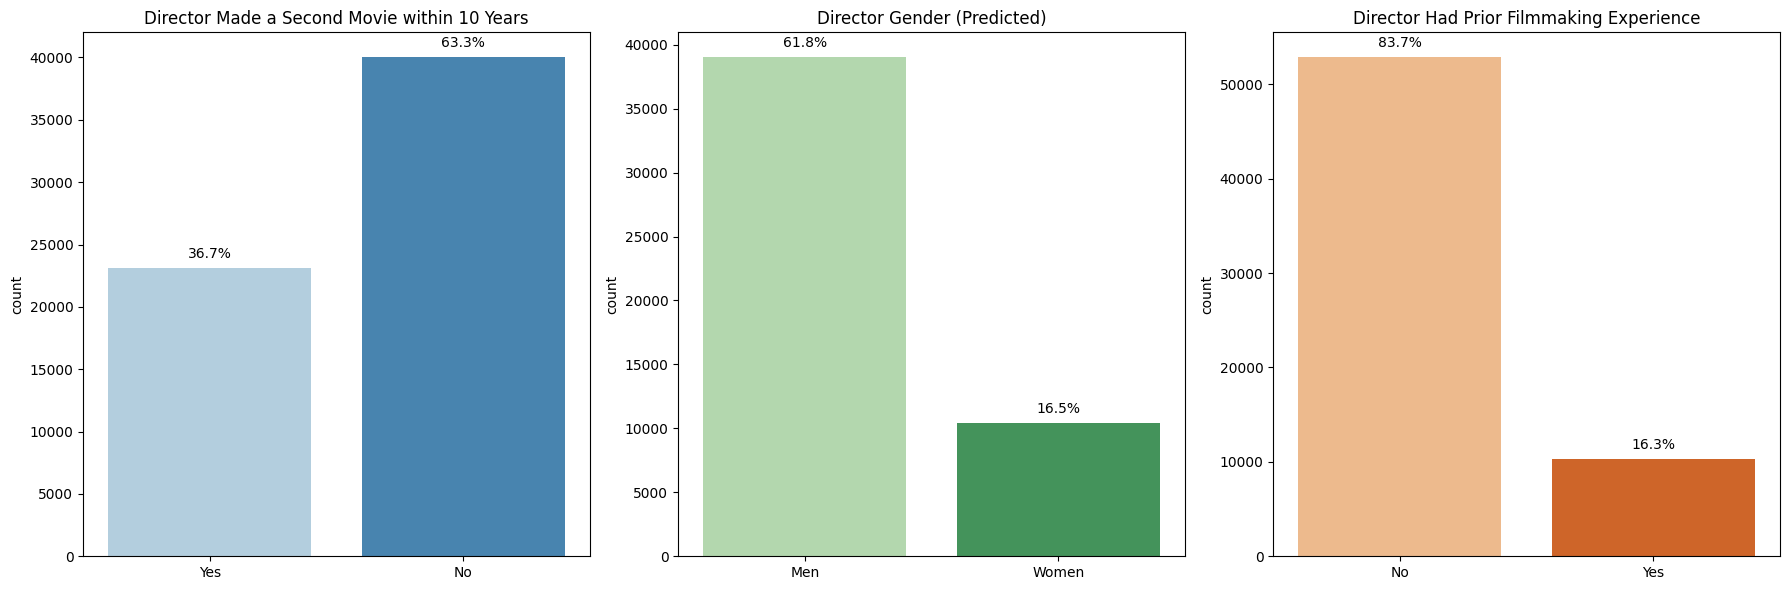

In [6]:
# Generate frequency counts for categorical variables
categorical_vars = ['event', 'director_predicted_gender_binary', 'had_prior_experience']

# Define the categorical variables with new labels and titles
categorical_variables_info = {
    'event': {
        'title': 'Director Made a Second Movie within 10 Years',
        'labels': {0: 'No', 1: 'Yes'},
        'palette': 'Blues'
    },
    'director_predicted_gender_binary': {
        'title': 'Director Gender (Predicted)',
        'labels': {0: 'Men', 1: 'Women'},
        'palette': 'Greens'
    },
    'had_prior_experience': {
        'title': 'Director Had Prior Filmmaking Experience',
        'labels': {0: 'No', 1: 'Yes'},
        'palette': 'Oranges'
    }
}
# Plot the bar charts for the categorical variables with new labels and titles
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot bar charts with updated labels and titles, using different hues within each variable
for i, (var, info) in enumerate(categorical_variables_info.items()):
    ax = sns.countplot(x=directors_cross_sectional_complete[var].map(info['labels']), 
                       hue=directors_cross_sectional_complete[var].map(info['labels']), 
                       ax=axs[i], palette=info['palette'], legend=False)
    axs[i].set_title(info['title'])
    axs[i].set_xlabel('')
    
    # Add percentages on top of the bars
    total = len(directors_cross_sectional_complete[var])
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height/total:.1%}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')

# Adjust layout
plt.tight_layout()
plt.show()



Given the skewness and presence of outliers in `debut_collaborator_avg_effective_size` and `collaborator_movie_votes`, a transformation could help normalize the distribution. We will do this in several ways:
1. Apply a logarithmic transformation to reduce the skewness. This is suitable for our data which contains zero or positive values.
2. Apply a square root transformation which can also help reduce skewness.
3. Winsorize the data to limit extreme values and reduce the impact of outliers. We will winsorizing the top 1% of the `debut_collaborator_avg_effective_size` variable. This means that the directors whose collaborators' effective size was in the top 1% will have it reduced to the 99th percentile value.

In [64]:
# Define the transformation functions
def log_transform(x):
    return np.log(x + 1)

def sqrt_transform(x):
    return np.sqrt(x)

def winsorize_transform(series, limits=[0, 0.01]):
    clean_data = series.dropna().values
    winsorized_clean_data = mstats.winsorize(clean_data, limits=limits)
    return pd.Series(winsorized_clean_data, index=series.dropna().index)

# List of variables to transform
variables = ['debut_collaborator_avg_effective_size', 'collaborator_movie_votes']

# Apply transformations using a loop
for var in variables:
    directors_cross_sectional_complete[f'{var}_log'] = directors_cross_sectional_complete[var].apply(log_transform)
    directors_cross_sectional_complete[f'{var}_sqrt'] = directors_cross_sectional_complete[var].apply(sqrt_transform)
    directors_cross_sectional_complete[f'{var}_winsorized'] = winsorize_transform(directors_cross_sectional_complete[var])

Let's take a look at the distribution of the orginal variable and the transformed variables.

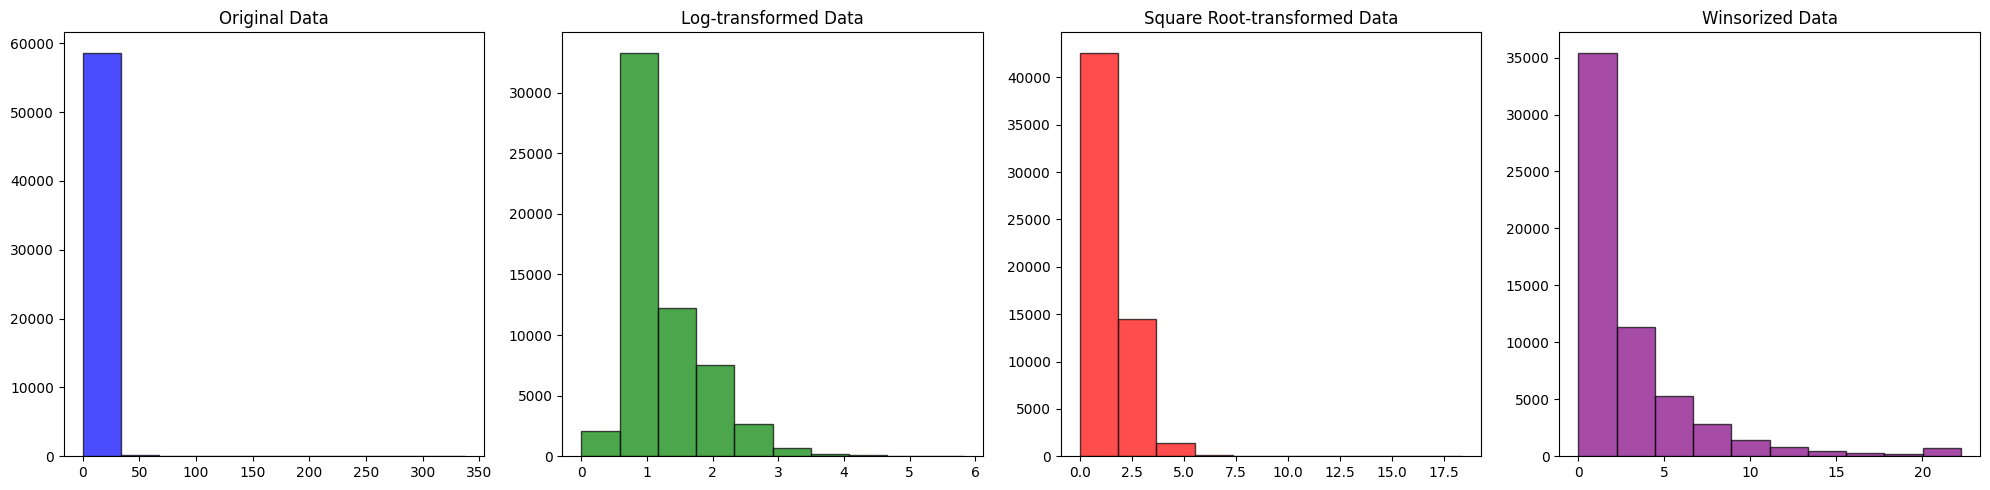

In [49]:
# Define the variables for histograms and their titles
variables = {
    'debut_collaborator_avg_effective_size': 'Original Data',
    'debut_collaborator_avg_effective_size_log': 'Log-transformed Data',
    'debut_collaborator_avg_effective_size_sqrt': 'Square Root-transformed Data',
    'debut_collaborator_avg_effective_size_winsorized': 'Winsorized Data'
}

# Define the colors for each histogram
colors = ['blue', 'green', 'red', 'purple']

# Plot the histograms for the specified variables, all in the same row with different colors
plt.figure(figsize=(20, 5))

for i, (var, title) in enumerate(variables.items()):
    plt.subplot(1, 4, i + 1)
    plt.hist(directors_cross_sectional_complete[var], bins=10, edgecolor='k', alpha=0.7, color=colors[i])
    plt.title(title)

plt.tight_layout()
plt.show()

In [ ]:
# Initialize the scaler for centering (mean removal only)
center_scaler = StandardScaler(with_mean=True, with_std=False)

# Initialize the scaler for standardization (mean removal and scaling to unit variance)
standardize_scaler = StandardScaler()

# Center debut_collaborator_avg_effective_size_winsorized
directors_cross_sectional_complete['debut_collaborator_avg_effective_size_winsorized_centered'] = center_scaler.fit_transform(
    directors_cross_sectional_complete[['debut_collaborator_avg_effective_size_winsorized']]
)

# Standardize collaborator_movie_ratings and collaborator_movie_votes_winsorized
columns_to_standardize = ['collaborator_movie_ratings', 'collaborator_movie_votes_winsorized']
directors_cross_sectional_complete[columns_to_standardize] = standardize_scaler.fit_transform(
    directors_cross_sectional_complete[columns_to_standardize]
)

# Rename the standardized columns to indicate the transformation
directors_cross_sectional_complete = directors_cross_sectional_complete.rename(columns={
    'collaborator_movie_ratings': 'collaborator_movie_ratings_standardized',
    'collaborator_movie_votes_winsorized': 'collaborator_movie_votes_winsorized_standardized'
})

In [68]:
directors_cross_sectional_complete.columns

Index(['nconst_director', 'debut_year', 'time_to_second_movie', 'event',
       'total_movies', 'debut_collaborator_avg_effective_size',
       'director_predicted_gender', 'director_predicted_gender_binary',
       'had_prior_experience', 'collaborator_movie_ratings_standardized',
       'collaborator_movie_votes', 'debut_year_2004', 'debut_year_2005',
       'debut_year_2006', 'debut_year_2007', 'debut_year_2008',
       'debut_year_2009', 'debut_year_2010', 'debut_year_2011',
       'debut_year_2012', 'debut_year_2013',
       'debut_collaborator_avg_effective_size_log',
       'debut_collaborator_avg_effective_size_sqrt',
       'debut_collaborator_avg_effective_size_winsorized',
       'collaborator_movie_votes_log', 'collaborator_movie_votes_sqrt',
       'collaborator_movie_votes_winsorized_standardized',
       'debut_collaborator_avg_effective_size_winsorized_centered'],
      dtype='object')

In [69]:
directors_cross_sectional_complete.to_csv("directors_cross_sectional_complete.csv", index = False)

In [14]:
# Generate descriptive statistics for all numeric variables 
# these include both continuous variables and categorical variables that were recoded to have numeric values
numeric_vars = ['event', 'time_to_second_movie',
             'debut_collaborator_avg_effective_size', 'director_predicted_gender_binary',
             'had_prior_experience', 'collaborator_movie_ratings', 'collaborator_movie_votes']

pd.set_option('display.float_format', lambda x: '%.2f' % x)  
directors_cross_sectional_complete[numeric_vars].describe()

,event,time_to_second_movie,debut_collaborator_avg_effective_size,director_predicted_gender_binary,had_prior_experience,collaborator_movie_ratings,collaborator_movie_votes
count,63169.00,63169.00,58869.00,49443.00,63169.00,40458.00,40458.00
mean,0.37,8.50,3.35,0.21,0.16,6.38,21041.95
std,0.48,3.64,7.63,0.41,0.37,1.21,165668.46
min,0.00,1.00,0.00,0.00,0.00,1.00,5.00
25%,0.00,5.00,1.00,0.00,0.00,5.70,34.00
50%,0.00,11.00,1.63,0.00,0.00,6.42,238.50
75%,1.00,11.00,3.74,0.00,0.00,7.15,2220.75
max,1.00,11.00,337.38,1.00,1.00,10.00,9762716.00


## 1.3. Correlation analyses 

In [82]:
# Define the variables
variables = ['event', 'time_to_second_movie',
             'debut_collaborator_avg_effective_size', 'director_predicted_gender_binary',
             'had_prior_experience', 'collaborator_movie_ratings', 'collaborator_movie_votes']

# Function to calculate pairwise correlations and their p-values with pairwise dropping of missing values
def calculate_pairwise_correlations(data, variables):
    correlation_matrix = pd.DataFrame(index=variables, columns=variables)
    p_values = pd.DataFrame(index=variables, columns=variables)
    
    for var1 in variables:
        for var2 in variables:
            if var1 != var2:
                valid_data = data[[var1, var2]].dropna()
                correlation, p_value = pearsonr(valid_data[var1], valid_data[var2])
                correlation_matrix.loc[var1, var2] = correlation
                p_values.loc[var1, var2] = p_value
            else:
                correlation_matrix.loc[var1, var2] = 1.0
                p_values.loc[var1, var2] = 0.0

    return correlation_matrix.apply(pd.to_numeric), p_values.apply(pd.to_numeric)

# Calculate the pairwise correlations and p-values
correlation_matrix, p_values = calculate_pairwise_correlations(directors_cross_sectional_complete, variables)

In [84]:
p_values[p_values > 0.001]

,event,time_to_second_movie,debut_collaborator_avg_effective_size,director_predicted_gender_binary,had_prior_experience,collaborator_movie_ratings,collaborator_movie_votes
event,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_to_second_movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN
debut_collaborator_avg_effective_size,NaN,NaN,NaN,0.00,NaN,NaN,NaN
director_predicted_gender_binary,NaN,NaN,0.00,NaN,NaN,NaN,NaN
had_prior_experience,NaN,NaN,NaN,NaN,NaN,NaN,NaN
collaborator_movie_ratings,NaN,NaN,NaN,NaN,NaN,NaN,0.01
collaborator_movie_votes,NaN,NaN,NaN,NaN,NaN,0.01,NaN


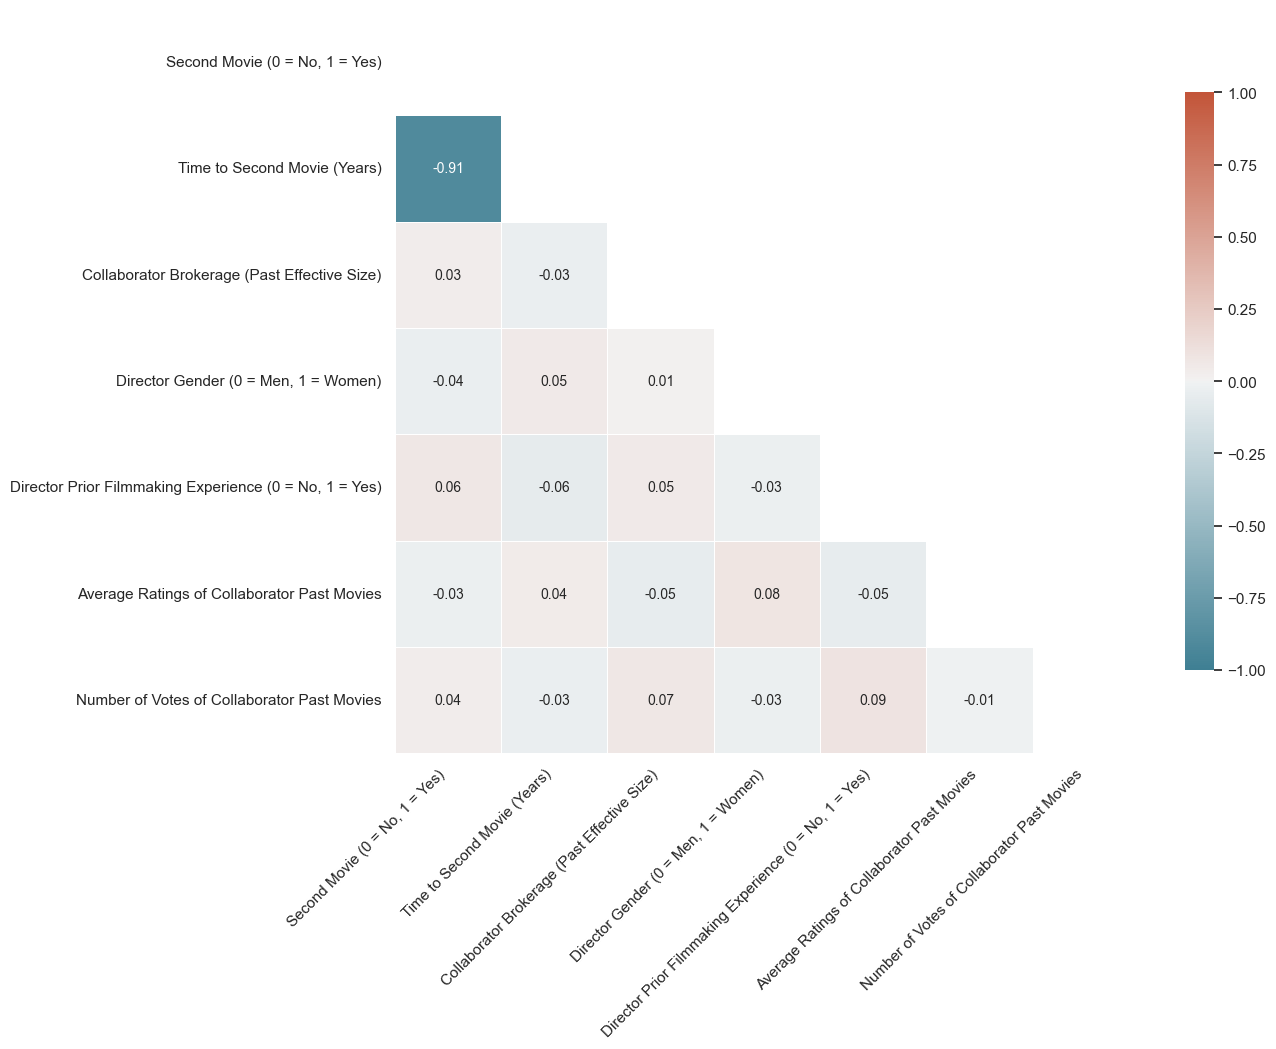

In [36]:
# Create a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap
plt.figure(figsize=(12, 10))
sns.set(style='white')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Custom labels for the heatmap
custom_labels = [
    'Second Movie (0 = No, 1 = Yes)', 'Time to Second Movie (Years)',
    'Collaborator Brokerage (Past Effective Size)', 'Director Gender (0 = Men, 1 = Women)',
    'Director Prior Filmmaking Experience (0 = No, 1 = Yes)', 
    'Average Ratings of Collaborator Past Movies', 'Number of Votes of Collaborator Past Movies'
]

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, fmt='.2f', annot_kws={"size": 10},
            cbar_kws={"shrink": .75})

# Modify x and y axis labels
plt.xticks(ticks=np.arange(len(custom_labels)) + 0.5, labels=custom_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(custom_labels)) + 0.5, labels=custom_labels, rotation=0)

plt.title('')
plt.show()


# 2. Preparing the panel data on directors' career from debut to 2023

The panel dataset will have the following columns:
- 'nconst_director': Unique identifier for each director.
- 'year': Year in a director's career.
- 'num_movies': Number of movies directed in a given year.
- 'made_movie': Indicator for whether the director made a movie in a given year.
- 'dropoutYear': Year the director dropped out of directing, active directors are assigned NA value
- 'dropout': Indicator for whether the director dropped out in a given year.
- 'start_time', 'stop_time': Time markers for survival analysis.
- 'collaborator_avg_effective_size', 'director_effective_size': Brokerage social capital of the director and their collaborators in a given year.
- 'director_predicted_gender': Gender of the director predicted by their first name.
- 'total_movies', 'average_rating', 'total_votes': Total number of movies directed, average ratings, and total number of votes for these movies in the three years prior to the current year.
- Genre Proportions (e.g., 'Action', 'Adventure', 'Animation'): Proportion of movies directed in each of the 25 genres three years prior to the current year.
- Year Dummies ('year_2004' to 'year_2023'): Dummy variables for each year from 2004 to 2023 to control for time-specific effects, with 2003 as the reference year.

## 2.1. Compling the data

In [2]:
# Load the datasets
file_paths = {
    "directors_gender": "directors_gender.csv",
    "directors_collaborator_social_capital": "directors_years_social_capital.csv",
    "directors_career_outcomes": "directors_years_outcomes.csv",
    "directors_control_variables": "directors_years_control_variables.csv"
}

datasets = {name: pd.read_csv(path) for name, path in file_paths.items()}

# Print column names for each dataset
for name, df in datasets.items():
    print(f"Column names in {name}:")
    print(df.columns)
    print("\n")

Column names in directors_gender:
Index(['nconst_director', 'director_predicted_gender',
       'director_predicted_gender_binary'],
      dtype='object')


Column names in directors_collaborator_social_capital:
Index(['nconst_director', 'year', 'debut_year', 'num_collaborators',
       'collaborator_avg_constraint', 'collaborator_max_constraint',
       'collaborator_avg_local_clustering',
       'collaborator_max_local_clustering',
       'collaborator_avg_reverse_constraint',
       'collaborator_max_reverse_constraint',
       'collaborator_avg_effective_size', 'collaborator_max_effective_size',
       'collaborator_avg_reverse_local_clustering',
       'collaborator_max_reverse_local_clustering',
       'collaborator_avg_degree_centrality',
       'collaborator_max_degree_centrality', 'debut_num_collaborators',
       'debut_collaborator_avg_constraint',
       'debut_collaborator_max_constraint',
       'debut_collaborator_avg_local_clustering',
       'debut_collaborator_max_loc

In [3]:
# Merge the datasets
directors_panel_complete = datasets["directors_career_outcomes"]

directors_panel_complete = directors_panel_complete.merge(
    datasets["directors_collaborator_social_capital"][['nconst_director', 'year', 'collaborator_avg_effective_size', 'director_effective_size']], 
    on=['nconst_director', 'year'], how="left")

directors_panel_complete = directors_panel_complete.merge(
    datasets["directors_gender"], 
    on=["nconst_director"], how="left")

directors_panel_complete = directors_panel_complete.merge(
    datasets["directors_control_variables"].drop(columns=['debut_year']), 
    on=['nconst_director', 'year'], how="left")

In [4]:
directors_panel_complete.head()

,nconst_director,year,debut_year,num_movies,made_movie,dropoutYear,dropout,start_time,stop_time,collaborator_avg_effective_size,...,debut_year_2004,debut_year_2005,debut_year_2006,debut_year_2007,debut_year_2008,debut_year_2009,debut_year_2010,debut_year_2011,debut_year_2012,debut_year_2013
0,nm1131265,2004,2004,0.0,0,NaN,0,0,1,0.000000,...,1,0,0,0,0,0,0,0,0,0
1,nm1131265,2005,2004,0.0,0,NaN,0,1,2,3.666667,...,1,0,0,0,0,0,0,0,0,0
2,nm1131265,2006,2004,0.0,0,NaN,0,2,3,3.644444,...,1,0,0,0,0,0,0,0,0,0
3,nm1131265,2007,2004,0.0,0,NaN,0,3,4,3.000000,...,1,0,0,0,0,0,0,0,0,0
4,nm1131265,2008,2004,0.0,0,NaN,0,4,5,0.000000,...,1,0,0,0,0,0,0,0,0,0


In [5]:
directors_panel_complete.columns

Index(['nconst_director', 'year', 'debut_year', 'num_movies', 'made_movie',
       'dropoutYear', 'dropout', 'start_time', 'stop_time',
       'collaborator_avg_effective_size', 'director_effective_size',
       'director_predicted_gender', 'director_predicted_gender_binary',
       'director_total_movies', 'director_raverage_rating',
       'director_total_votes', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance',
       'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western',
       'collaborator_total_movies', 'collaborator_movie_ratings',
       'collaborator_movie_votes', 'year_2004', 'year_2005', 'year_2006',
       'year_2007', 'year_2008', 'year_2009', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015', 'year_2016',
       'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021',
       'year_2022', 'y

## 2.2. Descriptive statistics and variable transformation 

In [15]:
# Calculate descriptive stats for person-year level variables
person_year_vars = [
    'made_movie', 'collaborator_avg_effective_size', 'director_effective_size', 
    'director_raverage_rating', 'director_total_votes',
    'collaborator_movie_ratings', 'collaborator_movie_votes',
    'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 
    'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western',
]
person_year_stats = directors_panel_complete[person_year_vars].describe().transpose()

In [13]:
person_year_stats

,count,mean,std,min,25%,50%,75%,max
made_movie,948320.0,0.058886,0.235412,0.0,0.0,0.0,0.00,1.000000e+00
collaborator_avg_effective_size,885549.0,1.560743,5.287578,0.0,0.0,0.0,1.00,3.960226e+02
director_effective_size,885549.0,0.710234,1.940268,0.0,0.0,0.0,1.00,1.100783e+02
director_raverage_rating,831619.0,1.423223,2.725747,0.0,0.0,0.0,0.00,1.000000e+01
director_total_votes,831619.0,910.878480,17363.676989,0.0,0.0,0.0,0.00,1.972743e+06
collaborator_movie_ratings,860384.0,1.859588,2.941689,0.0,0.0,0.0,5.25,1.000000e+01
collaborator_movie_votes,860384.0,10675.178389,128554.148381,0.0,0.0,0.0,26.00,1.330066e+07
Action,940809.0,0.009655,0.072634,0.0,0.0,0.0,0.00,1.000000e+00
Adventure,940809.0,0.005239,0.048140,0.0,0.0,0.0,0.00,1.000000e+00
Animation,940809.0,0.003524,0.046636,0.0,0.0,0.0,0.00,1.000000e+00


In [16]:
# Create a new DataFrame with the required columns
# then generate LaTeX table
latex_table = pd.DataFrame({
    'variable': person_year_stats.index,
    'N': person_year_stats['count'],
    'mean': person_year_stats['mean'],
    'sd': person_year_stats['std'],
    'minimum value': person_year_stats['min'],
    'maximum value': person_year_stats['max']
}).to_latex(index=False, float_format="%.2f", column_format='lcccc', header=True)

print(latex_table)

\begin{tabular}{lcccc}
\toprule
variable & N & mean & sd & minimum value & maximum value \\
\midrule
made_movie & 948320.00 & 0.06 & 0.24 & 0.00 & 1.00 \\
collaborator_avg_effective_size & 885549.00 & 1.56 & 5.29 & 0.00 & 396.02 \\
director_effective_size & 885549.00 & 0.71 & 1.94 & 0.00 & 110.08 \\
director_raverage_rating & 831619.00 & 1.42 & 2.73 & 0.00 & 10.00 \\
director_total_votes & 831619.00 & 910.88 & 17363.68 & 0.00 & 1972743.00 \\
collaborator_movie_ratings & 860384.00 & 1.86 & 2.94 & 0.00 & 10.00 \\
collaborator_movie_votes & 860384.00 & 10675.18 & 128554.15 & 0.00 & 13300660.00 \\
Action & 940809.00 & 0.01 & 0.07 & 0.00 & 1.00 \\
Adventure & 940809.00 & 0.01 & 0.05 & 0.00 & 1.00 \\
Animation & 940809.00 & 0.00 & 0.05 & 0.00 & 1.00 \\
Biography & 940809.00 & 0.01 & 0.05 & 0.00 & 1.00 \\
Comedy & 940809.00 & 0.03 & 0.15 & 0.00 & 1.00 \\
Crime & 940809.00 & 0.01 & 0.05 & 0.00 & 1.00 \\
Documentary & 940809.00 & 0.10 & 0.28 & 0.00 & 1.00 \\
Drama & 940809.00 & 0.08 & 0.23 & 0.

In [10]:
# Define the transformation functions
def log_transform(x):
    return np.log(x + 1)

def sqrt_transform(x):
    return np.sqrt(x)

def winsorize_transform(series, limits=[0, 0.01]):
    clean_data = series.dropna().values
    winsorized_clean_data = mstats.winsorize(clean_data, limits=limits)
    return pd.Series(winsorized_clean_data, index=series.dropna().index)

# List of variables to transform
variables = ['collaborator_avg_effective_size', 'director_effective_size', 'director_total_votes', 'collaborator_movie_votes']

# Apply transformations using a loop
for var in variables:
    directors_panel_complete[f'{var}_log'] = directors_panel_complete[var].apply(log_transform)
    directors_panel_complete[f'{var}_sqrt'] = directors_panel_complete[var].apply(sqrt_transform)
    directors_panel_complete[f'{var}_winsorized'] = winsorize_transform(directors_panel_complete[var])

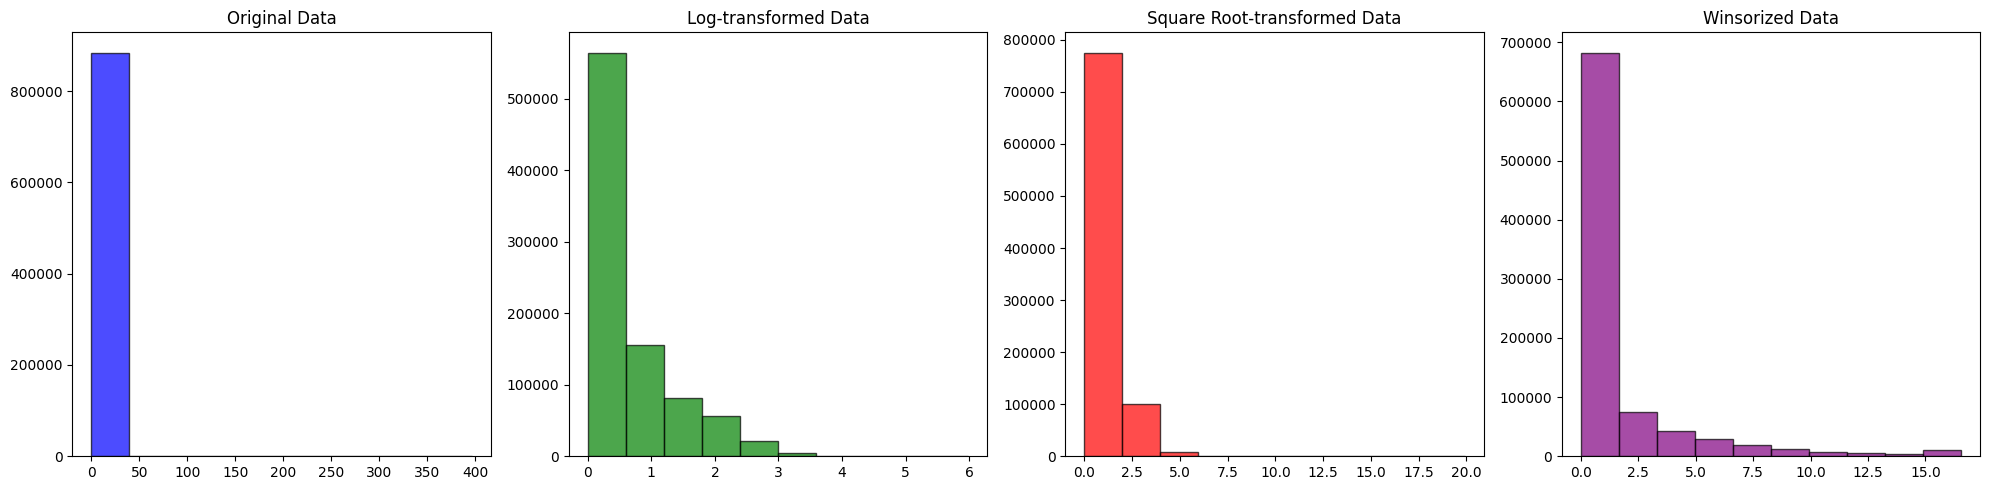

In [11]:
# Define the variables for histograms and their titles
variables = {
    'collaborator_avg_effective_size': 'Original Data',
    'collaborator_avg_effective_size_log': 'Log-transformed Data',
    'collaborator_avg_effective_size_sqrt': 'Square Root-transformed Data',
    'collaborator_avg_effective_size_winsorized': 'Winsorized Data'
}

# Define the colors for each histogram
colors = ['blue', 'green', 'red', 'purple']

# Plot the histograms for the specified variables, all in the same row with different colors
plt.figure(figsize=(20, 5))

for i, (var, title) in enumerate(variables.items()):
    plt.subplot(1, 4, i + 1)
    plt.hist(directors_panel_complete[var], bins=10, edgecolor='k', alpha=0.7, color=colors[i])
    plt.title(title)

plt.tight_layout()
plt.show()

In [18]:
# Standardize the continuous control variables to improve model stability
# Define the variables to standardize
variables_to_standardize = [
    'director_raverage_rating', 'collaborator_movie_ratings',
    'director_total_votes_winsorized', 'collaborator_movie_votes',
    'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 
    'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'
]

# Initialize the StandardScaler for standardization
scaler = StandardScaler()

# Standardize the variables
standardized_data = scaler.fit_transform(directors_panel_complete[variables_to_standardize])

# Create a DataFrame with the standardized variables
standardized_df = pd.DataFrame(standardized_data, columns=[var + '_standardized' for var in variables_to_standardize])

# Add the standardized variables back to the original DataFrame
directors_panel_complete = pd.concat([directors_panel_complete, standardized_df], axis=1)

In [32]:
# Define the variables to center
variables_to_center = [
    'collaborator_avg_effective_size', 'director_effective_size', 
    'collaborator_avg_effective_size_winsorized', 'director_effective_size_winsorized'
]

# Initialize the StandardScaler for centering
center_scaler = StandardScaler(with_mean=True, with_std=False)

# Center the specified variables
centered_data = center_scaler.fit_transform(directors_panel_complete[variables_to_center])

# Create a DataFrame with the centered variables
centered_df = pd.DataFrame(centered_data, columns=[var + '_centered' for var in variables_to_center])

# Add the centered variables back to the original DataFrame
directors_panel_complete = pd.concat([directors_panel_complete, centered_df], axis=1)


In [26]:
# # List of continuous variables to demean
# continuous_variables = [
#     'collaborator_avg_effective_size_winsorized',
#     'director_effective_size_winsorized', 
#     'average_rating',
#     'total_movies_winsorized', 
#     'total_votes_winsorized',
#     'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 
#     'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'
# ]

# # Calculate the means for each group
# group_means = directors_panel_complete.groupby('nconst_director')[continuous_variables].transform('mean')

# # Demean the continuous variables
# for var in continuous_variables:
#     directors_panel_complete[f'{var}_demeaned'] = directors_panel_complete[var] - group_means[var]

## 2.3. Correlation analyses

In [19]:
# Define the variables
variables = ['made_movie', 'collaborator_avg_effective_size', 'director_effective_size', 'director_predicted_gender_binary',
             'director_raverage_rating', 'director_total_votes',
             'collaborator_movie_ratings', 'collaborator_movie_votes',
             'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 
             'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'
             ]

# Function to calculate pairwise correlations and their p-values with pairwise dropping of missing values
def calculate_pairwise_correlations(data, variables):
    correlation_matrix = pd.DataFrame(index=variables, columns=variables)
    p_values = pd.DataFrame(index=variables, columns=variables)
    
    for var1 in variables:
        for var2 in variables:
            if var1 != var2:
                valid_data = data[[var1, var2]].dropna()
                correlation, p_value = pearsonr(valid_data[var1], valid_data[var2])
                correlation_matrix.loc[var1, var2] = correlation
                p_values.loc[var1, var2] = p_value
            else:
                correlation_matrix.loc[var1, var2] = 1.0
                p_values.loc[var1, var2] = 0.0

    return correlation_matrix.apply(pd.to_numeric), p_values.apply(pd.to_numeric)

# Calculate the pairwise correlations and p-values
correlation_matrix, p_values = calculate_pairwise_correlations(directors_panel_complete, variables)

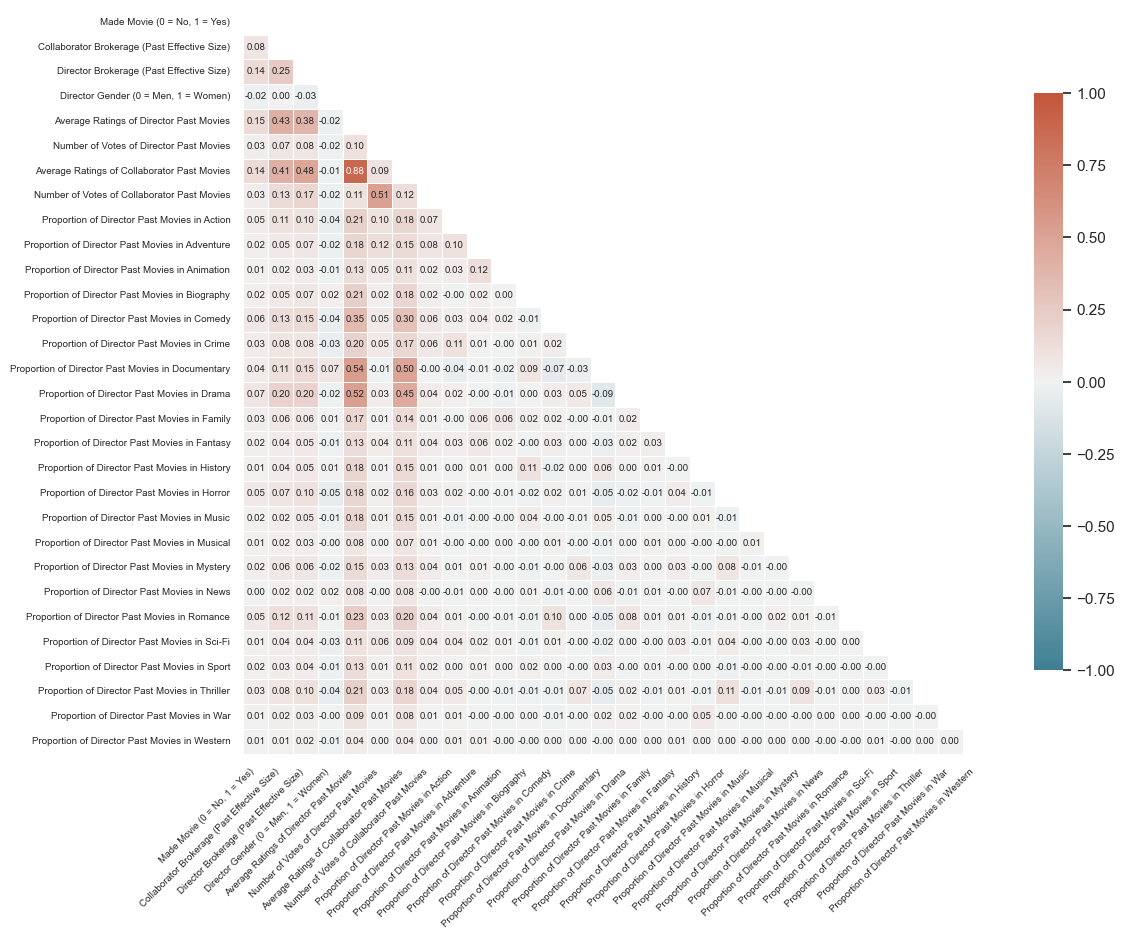

In [21]:
# Create a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap
plt.figure(figsize=(12, 10))
sns.set(style='white')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Custom labels for the heatmap
custom_labels = [
    'Made Movie (0 = No, 1 = Yes)',
    'Collaborator Brokerage (Past Effective Size)',
    'Director Brokerage (Past Effective Size)',
    'Director Gender (0 = Men, 1 = Women)',
    'Average Ratings of Director Past Movies',
    'Number of Votes of Director Past Movies',
    'Average Ratings of Collaborator Past Movies',
    'Number of Votes of Collaborator Past Movies',
    'Proportion of Director Past Movies in Action',
    'Proportion of Director Past Movies in Adventure',
    'Proportion of Director Past Movies in Animation',
    'Proportion of Director Past Movies in Biography',
    'Proportion of Director Past Movies in Comedy',
    'Proportion of Director Past Movies in Crime',
    'Proportion of Director Past Movies in Documentary',
    'Proportion of Director Past Movies in Drama',
    'Proportion of Director Past Movies in Family',
    'Proportion of Director Past Movies in Fantasy',
    'Proportion of Director Past Movies in History',
    'Proportion of Director Past Movies in Horror',
    'Proportion of Director Past Movies in Music',
    'Proportion of Director Past Movies in Musical',
    'Proportion of Director Past Movies in Mystery',
    'Proportion of Director Past Movies in News',
    'Proportion of Director Past Movies in Romance',
    'Proportion of Director Past Movies in Sci-Fi',
    'Proportion of Director Past Movies in Sport',
    'Proportion of Director Past Movies in Thriller',
    'Proportion of Director Past Movies in War',
    'Proportion of Director Past Movies in Western'
]

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, fmt='.2f', annot_kws={"size": 7},
            cbar_kws={"shrink": .75})

# Modify x and y axis labels
plt.xticks(ticks=np.arange(len(custom_labels)) + 0.5, labels=custom_labels, rotation=45, ha='right', fontsize=7)
plt.yticks(ticks=np.arange(len(custom_labels)) + 0.5, labels=custom_labels, rotation=0, fontsize=7)

plt.title('')
plt.show()


In [22]:
p_values[p_values > 0.05]

,made_movie,collaborator_avg_effective_size,director_effective_size,director_predicted_gender_binary,director_raverage_rating,director_total_votes,collaborator_movie_ratings,collaborator_movie_votes,Action,Adventure,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
made_movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.547319,NaN,NaN,NaN,NaN,NaN,NaN
collaborator_avg_effective_size,NaN,NaN,NaN,0.632655,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director_effective_size,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director_predicted_gender_binary,NaN,0.632655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.076361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director_raverage_rating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director_total_votes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.311845,NaN,NaN,NaN,NaN,NaN,0.354730
collaborator_movie_ratings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
collaborator_movie_votes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.709766,NaN,NaN,NaN,NaN,NaN,NaN
Action,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.239652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adventure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.372423,NaN,NaN,NaN,NaN,NaN,0.759522,0.062116,NaN


## 2.4. Saving the final dataset

In [33]:
directors_panel_complete.columns

Index(['nconst_director', 'year', 'debut_year', 'num_movies', 'made_movie',
       'dropoutYear', 'dropout', 'start_time', 'stop_time',
       'collaborator_avg_effective_size',
       ...
       'Romance_standardized', 'Sci-Fi_standardized', 'Sport_standardized',
       'Thriller_standardized', 'War_standardized', 'Western_standardized',
       'collaborator_avg_effective_size_centered',
       'director_effective_size_centered',
       'collaborator_avg_effective_size_winsorized_centered',
       'director_effective_size_winsorized_centered'],
      dtype='object', length=114)

In [34]:
# List of prefixes to identify columns to drop
prefixes = [
    'director_raverage_rating', 'director_total_votes', 'director_total_movies',
    'collaborator_movie_ratings', 'collaborator_movie_votes', 'collaborator_total_movies', 
    'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 
    'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'
]

# Identify columns to keep (those ending with '_demeaned')
columns_to_keep = [col for col in directors_panel_complete.columns if col.endswith('_standardized')]

# Identify columns to drop
columns_to_drop = [col for col in directors_panel_complete.columns if any(col.startswith(prefix) for prefix in prefixes) and col not in columns_to_keep]

In [37]:
# Drop the identified columns
directors_panel_complete = directors_panel_complete.drop(columns=columns_to_drop)

In [43]:
#directors_panel_complete = directors_panel_complete[directors_panel_complete['start_time'] <= 10]

,nconst_director,year,debut_year,num_movies,made_movie,dropoutYear,dropout,start_time,stop_time,collaborator_avg_effective_size,...,Romance_standardized,Sci-Fi_standardized,Sport_standardized,Thriller_standardized,War_standardized,Western_standardized,collaborator_avg_effective_size_centered,director_effective_size_centered,collaborator_avg_effective_size_winsorized_centered,director_effective_size_winsorized_centered
0,nm1131265,2004,2004,0.0,0,NaN,0,0,1,0.000000,...,-0.140874,-0.074932,-0.069136,-0.142069,-0.054748,-0.028336,-1.560743,-0.710234,-1.418436,-0.65989
1,nm1131265,2005,2004,0.0,0,NaN,0,1,2,3.666667,...,-0.140874,-0.074932,-0.069136,-0.142069,-0.054748,-0.028336,2.105924,0.289766,2.248230,0.34011
2,nm1131265,2006,2004,0.0,0,NaN,0,2,3,3.644444,...,-0.140874,-0.074932,-0.069136,-0.142069,-0.054748,-0.028336,2.083702,0.289766,2.226008,0.34011
3,nm1131265,2007,2004,0.0,0,NaN,0,3,4,3.000000,...,-0.140874,-0.074932,-0.069136,-0.142069,-0.054748,-0.028336,1.439257,0.289766,1.581564,0.34011
4,nm1131265,2008,2004,0.0,0,NaN,0,4,5,0.000000,...,-0.140874,-0.074932,-0.069136,-0.142069,-0.054748,-0.028336,-1.560743,-0.710234,-1.418436,-0.65989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948307,nm0994435,2011,2005,0.0,0,2006.0,1,6,7,0.000000,...,-0.140874,-0.074932,-0.069136,-0.142069,-0.054748,-0.028336,-1.560743,-0.710234,-1.418436,-0.65989
948308,nm0994435,2012,2005,0.0,0,2006.0,1,7,8,0.000000,...,-0.140874,-0.074932,-0.069136,-0.142069,-0.054748,-0.028336,-1.560743,-0.710234,-1.418436,-0.65989
948309,nm0994435,2013,2005,0.0,0,2006.0,1,8,9,0.000000,...,-0.140874,-0.074932,-0.069136,-0.142069,-0.054748,-0.028336,-1.560743,-0.710234,-1.418436,-0.65989
948310,nm0994435,2014,2005,0.0,0,2006.0,1,9,10,0.000000,...,-0.140874,-0.074932,-0.069136,-0.142069,-0.054748,-0.028336,-1.560743,-0.710234,-1.418436,-0.65989


In [47]:
directors_panel_complete.to_csv("directors_panel_complete.csv", index=False)